In [1]:
# see test file test_burgers_initial_vs_pypde.sh
# this file runs the second part of the test, runs PyPDE and compares the results

In [2]:
import numpy as np
import pandas as pd
import sys
import os
from glob import glob
from json import load as json_load
from numpy.fft import fft,ifft,fftfreq,fftshift
from numpy import sin,cos,exp,log,sqrt,pi

## Matplotlib Parameters

In [3]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

In [4]:
colors = plt.cm.Blues(np.linspace(0,1,10))
colors = plt.cm.viridis(np.linspace(1,0,10))

In [5]:
#rcParams['lines.linewidth'] = 2
#rcParams['lines.linestyle'] = '--'
rcParams['axes.titlesize'] = 16
rcParams['axes.labelsize'] = 16
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['text.usetex'] = True
rcParams['text.latex.preamble'] = r'\usepackage{amsfonts}'
#rcParams['font.family'] = "sans-serif"
#rcParams['font.family'] = ["Helvetica"]
#rcParams['font.sans-serif'] = ['Helvetica']

In [6]:
from matplotlib.ticker import FuncFormatter

def format_basis10(x):
    return np.sign(x)*10**(-np.floor(np.log10(abs(x)))+np.log10(abs(x)))

def format_exp10(x):
    return np.floor(np.log10(abs(x)))

def MyFormatter(x,lim):
    if x == 0:
        return f'$0$'
    return f'${format_basis10(x):.1f} \\times 10^{{{format_exp10(x):.0f}}}$'
    #The first argument of the format gives the first significant digits of the number with the sign preserved and brought to a range between [1-10), The next argument gives the  numbers integer exponent of 10
    #Both the first and second arguments are formatted to display only 2 decimal places due to the lack of space.
    
majorFormatter = FuncFormatter(MyFormatter)

## Load data

In [7]:
# parent directory
path = os.path.abspath(os.path.join(os.path.abspath(''), os.pardir))
sys.path.append(path+'/scripts')

In [8]:
from _functions import *

In [9]:
# hashes are saved with 10 characters, hence 10 ?
# is there a better way to do this without regex ?
all_files = glob(f'{path}/data/params_??????????.json')
all_files.sort()

In [10]:
all_files

['/Users/bt308146/Github/burgers-spectral-python/data/params_007ad8ca93.json',
 '/Users/bt308146/Github/burgers-spectral-python/data/params_5c839169f0.json']

In [11]:
for i,file_path in enumerate(all_files):
    with open(file_path,'r') as file:
        if i==0:
            json_data = json_load(file)
            df = pd.DataFrame([json_data])
        else:
            json_data = json_load(file)
            df.loc[i] = json_data

In [12]:
df

,BN,Lrelative,Ttotal,N,nu,Ltotal,L,sqeps,dx,NT,...,sqdx,cfl_const,dt,nlinear,fkernel,initial_value,scheme,saveformat,R,dict_hash
0,4,0.125,10.0,16,0.01,1.0,0.125,1.0,0.062500,25600,...,0.2500,0.1,0.000391,False,zero_smooth_fourier_forcing,zero_initial,ETD,fourier,0,007ad8ca93
1,8,0.125,1.0,256,0.01,1.0,0.125,1.0,0.003906,655360,...,0.0625,0.1,0.000002,True,zero_forcing,sine_initial,ETD,real,0,5c839169f0


In [13]:
prefix = 0

BN              = df.at[prefix,'BN']
Lrelative       = df.at[prefix,'Lrelative']
Ttotal          = df.at[prefix,'Ttotal']
N               = df.at[prefix,'N']
nu              = df.at[prefix,'nu']
Ltotal          = df.at[prefix,'Ltotal']
L               = df.at[prefix,'L']
sqeps           = df.at[prefix,'sqeps']
dx              = df.at[prefix,'dx']
NT              = df.at[prefix,'NT']
NTsave          = df.at[prefix,'NTsave']
viscte          = df.at[prefix,'viscte']
sqdx            = df.at[prefix,'sqdx']
cfl_const       = df.at[prefix,'cfl_const']
dt              = df.at[prefix,'dt']
nlinear         = df.at[prefix,'nlinear']
fkernel         = df.at[prefix,'fkernel']
initial_value   = df.at[prefix,'initial_value']
scheme          = df.at[prefix,'scheme']
saveformat      = df.at[prefix,'saveformat']
R               = df.at[prefix,'R']
dict_hash       = df.at[prefix,'dict_hash']

# Ensemble specifications

In [14]:
file_suffix = f'R_{R:05d}_{dict_hash}'

In [15]:
# hashes are saved with 10 characters, hence 10 ?
# is there a better way to do this without regex ?
all_files = glob(f'{path}/data/burgers_R_*_{dict_hash}.npz')
all_files.sort()

In [16]:
ens_size = len(all_files)

In [17]:
ens_size

300

# Plot Velocity Field Profiles

In [18]:
vfourier = np.load(path+'/data/burgers_'+file_suffix+'.npz')['u']

In [19]:
vspace = ifft(vfourier,axis=1)

In [20]:
X = fftshift( fftfreq(N) * Ltotal )

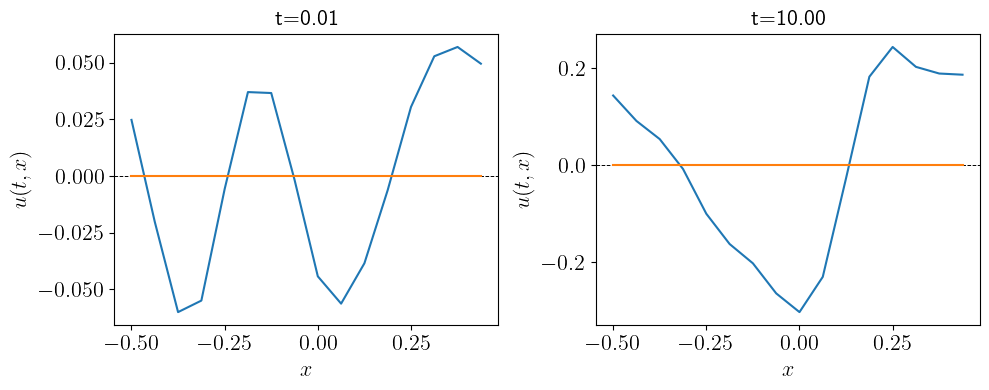

In [21]:
# initial profile of velocity field
fig, ax = plt.subplots(1,2, figsize=(10,4))

t_slice = 0
ax[0].set_title(f"t={(t_slice+1)/NTsave*Ttotal:.2f}")
ax[0].set_ylabel("$u(t,x)$")
ax[0].set_xlabel("$x$")
ax[0].axhline(y=0,linestyle='dashed',color='k',linewidth=0.7) # axis line
ax[0].plot(X,np.real(np.fft.fftshift(vspace[0,:])),label='real part')
ax[0].plot(X,np.imag(np.fft.fftshift(vspace[0,:])),label='real part')

t_slice = NTsave-1
# final profile of velocity field
ax[1].set_title(f"t={(t_slice+1)/NTsave*Ttotal:.2f}")
ax[1].set_ylabel("$u(t,x)$")
ax[1].set_xlabel("$x$")
ax[1].axhline(y=0,linestyle='dashed',color='k',linewidth=0.7) # axis line
ax[1].plot(X,np.real(np.fft.fftshift(vspace[t_slice,:])))
ax[1].plot(X,np.imag(np.fft.fftshift(vspace[t_slice,:])))

plt.tight_layout()
#plt.savefig(f'{path}/figs/bwn_velocity_profile_finite.png', dpi=200, facecolor='white', transparent=False)
plt.show()

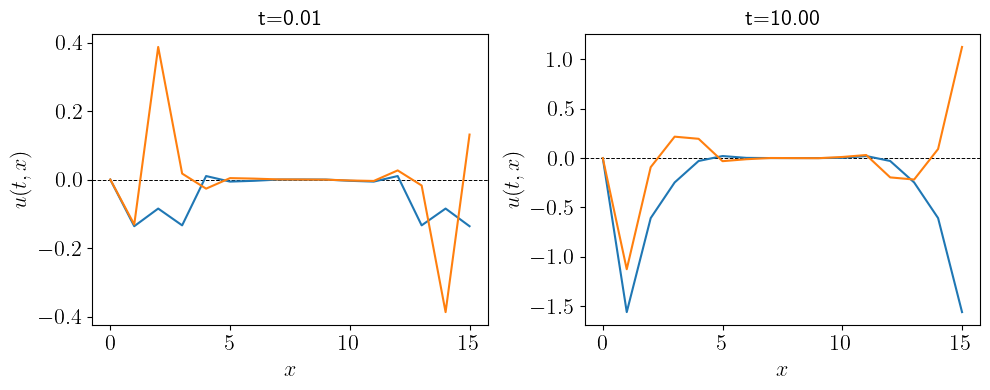

In [22]:
# fourier profile of velocity field, fourier space
fig, ax = plt.subplots(1,2, figsize=(10,4))

t_slice = 0
ax[0].set_title(f"t={(t_slice+1)/NTsave*Ttotal:.2f}")
ax[0].set_ylabel("$u(t,x)$")
ax[0].set_xlabel("$x$")
ax[0].axhline(y=0,linestyle='dashed',color='k',linewidth=0.7) # axis line
ax[0].plot(np.real(fft(vspace[t_slice,:])),label='real part')
ax[0].plot(np.imag(fft(vspace[t_slice,:])),label='imag part')

t_slice = NTsave-1
# final profile of velocity field
ax[1].set_title(f"t={(t_slice+1)/NTsave*Ttotal:.2f}")
ax[1].set_ylabel("$u(t,x)$")
ax[1].set_xlabel("$x$")
ax[1].axhline(y=0,linestyle='dashed',color='k',linewidth=0.7) # axis line
ax[1].plot(np.real(fft(vspace[t_slice,:])),label='real part')
ax[1].plot(np.imag(fft(vspace[t_slice,:])),label='imag part')

plt.tight_layout()
#plt.savefig(f'{path}/figs/bwn_velocity_profile_finite.png', dpi=200, facecolor='white', transparent=False)
plt.show()

# Force statistics

check force variance
Parseval theorem states that variance in Fourier and real space is the same
for the DFT, the theorem is

$$
\sum_n \mathbb{E}|u_n|^2 = \frac{1}{N} \sum_k \mathbb{E}|\widehat{u}_k|^2 = \frac{1}{N} \sum_k \hat{C}_f(k)
$$

In [90]:
f_var_fourier = 0.
f_var_space   = 0.

for R in range(ens_size):
    
    file_name = f'{path}/data/burgers_R_{R:05d}_{dict_hash}.npz'
    
    ffourier = np.load(file_name)['f']
    
    fspace   = ifft(ffourier,axis=1)
    
    #f_avg += np.mean( ffourier )
    f_var_fourier += np.mean( np.abs(ffourier)**2 )
    f_var_space   += np.mean( np.abs(fspace)**2 )
    
f_var_space   *= 1./ens_size
f_var_fourier *= 1./ens_size

In [91]:
def force_corrf_zero_smooth_fourier(k):
    
    kernel  = 4*sqrt(2*pi)*k**2*L**3*pi**2
    kernel *= exp(-2*pi**2*L**2*k**2) # exponential correlation function
    
    return kernel


K = np.fft.fftfreq(N) * N

f_var_analyt = np.sum( force_corrf_zero_smooth_fourier(K) ) * dx

In [92]:
print(f'parseval absolute diff = {np.abs(f_var_space - f_var_fourier / N)}')
print(f'parseval absolute diff = {np.abs(f_var_fourier / N - f_var_analyt)}')

parseval absolute diff = 0.0
parseval absolute diff = 4.016122598556743e-05


In [45]:
file_suffix

'R_00000_007ad8ca93'

In [48]:
f_all = np.array([])

for i in range(ens_size):
    
    file_name = f'{path}/data/burgers_R_{i:05d}_{dict_hash}.npz'
    
    fspace = ifft( np.load(file_name)['f'] , axis=1).flatten()
    
    f_all = np.concatenate(( f_all, fspace ))

In [49]:
hist, bin_edges = np.histogram( np.real(f_all), bins=300, density=True )

bin_centers = .5*bin_edges[1:] + .5*bin_edges[:-1]

In [50]:
def f_pdf(f,sigma2):
    
    cte = 1./sqrt(2.*pi*sigma2)
    
    return cte*exp(-.5*f**2/sigma2)

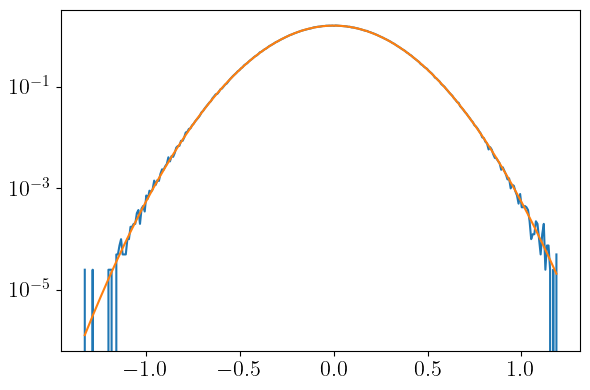

In [51]:
fig,ax = plt.subplots(1,1,figsize=(6,4))

ax.plot(bin_centers, hist)

ax.plot(bin_centers, f_pdf(bin_centers,f_var_analyt))

ax.set_yscale('log')

plt.tight_layout()
plt.show()

## Velocity Fourier Variance in Time

In [89]:
v_var_time = np.zeros(NTsave)

for R in range(ens_size):
    
    file_name = f'{path}/data/burgers_R_{R:05d}_{dict_hash}.npz'
    
    vfourier    = np.load(file_name)['u']
    
    vspace      = ifft(vfourier,axis=1)
    
    v_var_time += np.mean( np.abs(vfourier)**2 * dx , axis=1 )
    
v_var_time *= 1./ens_size

In [61]:
t_axis = np.arange(1,NTsave+1)/NTsave*Ttotal

In [62]:
# data copied from mathematica, HeatAnalytical.nb
v_var_time_analytical = [0.00981201, 0.0192634, 0.0283756, 0.0371686, 0.0456606, 0.0538682, \
0.0618072, 0.0694917, 0.0769351, 0.0841498, 0.0911472, 0.0979381, \
0.104532, 0.110939, 0.117168, 0.123225, 0.129121, 0.13486, 0.14045, \
0.145898, 0.15121, 0.15639, 0.161445, 0.166378, 0.171196, 0.175903, \
0.180502, 0.184998, 0.189394, 0.193694, 0.197903, 0.202022, 0.206055, \
0.210004, 0.213874, 0.217666, 0.221383, 0.225027, 0.228602, 0.232108, \
0.235548, 0.238924, 0.242239, 0.245493, 0.248689, 0.251829, 0.254913, \
0.257945, 0.260924, 0.263854, 0.266734, 0.269567, 0.272353, 0.275094, \
0.277792, 0.280447, 0.28306, 0.285633, 0.288166, 0.29066, 0.293118, \
0.295538, 0.297923, 0.300273, 0.302589, 0.304872, 0.307122, 0.30934, \
0.311528, 0.313686, 0.315813, 0.317912, 0.319983, 0.322026, 0.324042, \
0.326032, 0.327995, 0.329934, 0.331847, 0.333736, 0.335601, 0.337443, \
0.339263, 0.341059, 0.342834, 0.344587, 0.346319, 0.348031, 0.349722, \
0.351393, 0.353045, 0.354677, 0.35629, 0.357885, 0.359462, 0.361021, \
0.362563, 0.364087, 0.365594, 0.367085, 0.368559, 0.370018, 0.37146, \
0.372887, 0.374299, 0.375695, 0.377077, 0.378444, 0.379797, 0.381136, \
0.382461, 0.383772, 0.38507, 0.386354, 0.387626, 0.388885, 0.390131, \
0.391364, 0.392585, 0.393795, 0.394992, 0.396177, 0.397351, 0.398514, \
0.399665, 0.400805, 0.401934, 0.403052, 0.404159, 0.405256, 0.406343, \
0.407419, 0.408486, 0.409542, 0.410588, 0.411625, 0.412652, 0.41367, \
0.414678, 0.415677, 0.416667, 0.417647, 0.418619, 0.419582, 0.420537, \
0.421482, 0.42242, 0.423348, 0.424269, 0.425181, 0.426086, 0.426982, \
0.42787, 0.428751, 0.429623, 0.430488, 0.431346, 0.432196, 0.433038, \
0.433874, 0.434702, 0.435522, 0.436336, 0.437143, 0.437943, 0.438735, \
0.439522, 0.440301, 0.441074, 0.44184, 0.442599, 0.443352, 0.444099, \
0.44484, 0.445574, 0.446302, 0.447024, 0.447739, 0.448449, 0.449153, \
0.449851, 0.450543, 0.451229, 0.45191, 0.452585, 0.453254, 0.453918, \
0.454576, 0.455229, 0.455876, 0.456518, 0.457155, 0.457786, 0.458412, \
0.459033, 0.459649, 0.46026, 0.460866, 0.461467, 0.462063, 0.462654, \
0.46324, 0.463822, 0.464398, 0.46497, 0.465538, 0.466101, 0.466659, \
0.467212, 0.467761, 0.468306, 0.468846, 0.469382, 0.469914, 0.470441, \
0.470964, 0.471483, 0.471997, 0.472508, 0.473014, 0.473516, 0.474014, \
0.474508, 0.474998, 0.475485, 0.475967, 0.476445, 0.47692, 0.477391, \
0.477858, 0.478321, 0.47878, 0.479236, 0.479688, 0.480137, 0.480582, \
0.481023, 0.481461, 0.481895, 0.482326, 0.482754, 0.483178, 0.483598, \
0.484016, 0.48443, 0.48484, 0.485248, 0.485652, 0.486053, 0.48645, \
0.486845, 0.487236, 0.487625, 0.48801, 0.488392, 0.488771, 0.489147, \
0.48952, 0.489891, 0.490258, 0.490622, 0.490983, 0.491342, 0.491698, \
0.49205, 0.4924, 0.492748, 0.493092, 0.493434, 0.493773, 0.494109, \
0.494443, 0.494774, 0.495103, 0.495429, 0.495752, 0.496073, 0.496391, \
0.496706, 0.49702, 0.49733, 0.497638, 0.497944, 0.498248, 0.498549, \
0.498847, 0.499143, 0.499437, 0.499729, 0.500018, 0.500305, 0.50059, \
0.500872, 0.501152, 0.50143, 0.501706, 0.50198, 0.502251, 0.502521, \
0.502788, 0.503053, 0.503316, 0.503577, 0.503836, 0.504092, 0.504347, \
0.5046, 0.504851, 0.5051, 0.505346, 0.505591, 0.505834, 0.506075, \
0.506315, 0.506552, 0.506787, 0.507021, 0.507252, 0.507482, 0.50771, \
0.507937, 0.508161, 0.508384, 0.508605, 0.508824, 0.509041, 0.509257, \
0.509471, 0.509684, 0.509894, 0.510103, 0.510311, 0.510517, 0.510721, \
0.510923, 0.511124, 0.511323, 0.511521, 0.511717, 0.511912, 0.512105, \
0.512297, 0.512487, 0.512676, 0.512863, 0.513048, 0.513233, 0.513415, \
0.513597, 0.513777, 0.513955, 0.514132, 0.514308, 0.514482, 0.514655, \
0.514827, 0.514997, 0.515166, 0.515333, 0.515499, 0.515664, 0.515828, \
0.51599, 0.516151, 0.516311, 0.516469, 0.516627, 0.516783, 0.516938, \
0.517091, 0.517244, 0.517395, 0.517545, 0.517693, 0.517841, 0.517988, \
0.518133, 0.518277, 0.51842, 0.518562, 0.518703, 0.518843, 0.518981, \
0.519119, 0.519255, 0.51939, 0.519525, 0.519658, 0.51979, 0.519921, \
0.520051, 0.52018, 0.520308, 0.520435, 0.520562, 0.520687, 0.520811, \
0.520934, 0.521056, 0.521177, 0.521297, 0.521417, 0.521535, 0.521652, \
0.521769, 0.521884, 0.521999, 0.522113, 0.522226, 0.522338, 0.522449, \
0.522559, 0.522668, 0.522777, 0.522884, 0.522991, 0.523097, 0.523202, \
0.523307, 0.52341, 0.523513, 0.523615, 0.523716, 0.523816, 0.523915, \
0.524014, 0.524112, 0.524209, 0.524305, 0.524401, 0.524496, 0.52459, \
0.524683, 0.524776, 0.524868, 0.524959, 0.52505, 0.525139, 0.525228, \
0.525317, 0.525404, 0.525491, 0.525578, 0.525663, 0.525748, 0.525832, \
0.525916, 0.525999, 0.526081, 0.526163, 0.526244, 0.526324, 0.526404, \
0.526483, 0.526562, 0.526639, 0.526717, 0.526793, 0.526869, 0.526945, \
0.52702, 0.527094, 0.527168, 0.527241, 0.527313, 0.527385, 0.527457, \
0.527527, 0.527598, 0.527667, 0.527737, 0.527805, 0.527873, 0.527941, \
0.528008, 0.528074, 0.52814, 0.528206, 0.528271, 0.528335, 0.528399, \
0.528462, 0.528525, 0.528588, 0.52865, 0.528711, 0.528772, 0.528833, \
0.528893, 0.528952, 0.529011, 0.52907, 0.529128, 0.529186, 0.529243, \
0.5293, 0.529356, 0.529412, 0.529467, 0.529522, 0.529577, 0.529631, \
0.529685, 0.529738, 0.529791, 0.529843, 0.529895, 0.529947, 0.529998, \
0.530049, 0.5301, 0.53015, 0.530199, 0.530249, 0.530297, 0.530346, \
0.530394, 0.530442, 0.530489, 0.530536, 0.530583, 0.530629, 0.530675, \
0.53072, 0.530765, 0.53081, 0.530855, 0.530899, 0.530943, 0.530986, \
0.531029, 0.531072, 0.531114, 0.531156, 0.531198, 0.531239, 0.53128, \
0.531321, 0.531362, 0.531402, 0.531441, 0.531481, 0.53152, 0.531559, \
0.531598, 0.531636, 0.531674, 0.531711, 0.531749, 0.531786, 0.531823, \
0.531859, 0.531895, 0.531931, 0.531967, 0.532002, 0.532037, 0.532072, \
0.532107, 0.532141, 0.532175, 0.532209, 0.532242, 0.532275, 0.532308, \
0.532341, 0.532373, 0.532405, 0.532437, 0.532469, 0.5325, 0.532532, \
0.532562, 0.532593, 0.532624, 0.532654, 0.532684, 0.532713, 0.532743, \
0.532772, 0.532801, 0.53283, 0.532858, 0.532887, 0.532915, 0.532943, \
0.532971, 0.532998, 0.533025, 0.533052, 0.533079, 0.533106, 0.533132, \
0.533158, 0.533184, 0.53321, 0.533236, 0.533261, 0.533286, 0.533311, \
0.533336, 0.53336, 0.533385, 0.533409, 0.533433, 0.533457, 0.533481, \
0.533504, 0.533527, 0.53355, 0.533573, 0.533596, 0.533619, 0.533641, \
0.533663, 0.533685, 0.533707, 0.533729, 0.53375, 0.533771, 0.533793, \
0.533814, 0.533834, 0.533855, 0.533876, 0.533896, 0.533916, 0.533936, \
0.533956, 0.533976, 0.533995, 0.534015, 0.534034, 0.534053, 0.534072, \
0.534091, 0.534109, 0.534128, 0.534146, 0.534164, 0.534183, 0.5342, \
0.534218, 0.534236, 0.534253, 0.534271, 0.534288, 0.534305, 0.534322, \
0.534339, 0.534356, 0.534372, 0.534389, 0.534405, 0.534421, 0.534437, \
0.534453, 0.534469, 0.534485, 0.5345, 0.534516, 0.534531, 0.534546, \
0.534561, 0.534576, 0.534591, 0.534606, 0.53462, 0.534635, 0.534649, \
0.534663, 0.534677, 0.534691, 0.534705, 0.534719, 0.534733, 0.534747, \
0.53476, 0.534773, 0.534787, 0.5348, 0.534813, 0.534826, 0.534839, \
0.534852, 0.534864, 0.534877, 0.534889, 0.534902, 0.534914, 0.534926, \
0.534938, 0.53495, 0.534962, 0.534974, 0.534986, 0.534997, 0.535009, \
0.53502, 0.535031, 0.535043, 0.535054, 0.535065, 0.535076, 0.535087, \
0.535098, 0.535108, 0.535119, 0.53513, 0.53514, 0.53515, 0.535161, \
0.535171, 0.535181, 0.535191, 0.535201, 0.535211, 0.535221, 0.535231, \
0.53524, 0.53525, 0.53526, 0.535269, 0.535278, 0.535288, 0.535297, \
0.535306, 0.535315, 0.535324, 0.535333, 0.535342, 0.535351, 0.53536, \
0.535368, 0.535377, 0.535385, 0.535394, 0.535402, 0.535411, 0.535419, \
0.535427, 0.535435, 0.535443, 0.535451, 0.535459, 0.535467, 0.535475, \
0.535483, 0.53549, 0.535498, 0.535506, 0.535513, 0.535521, 0.535528, \
0.535535, 0.535543, 0.53555, 0.535557, 0.535564, 0.535571, 0.535578, \
0.535585, 0.535592, 0.535599, 0.535606, 0.535612, 0.535619, 0.535626, \
0.535632, 0.535639, 0.535645, 0.535652, 0.535658, 0.535664, 0.535671, \
0.535677, 0.535683, 0.535689, 0.535695, 0.535701, 0.535707, 0.535713, \
0.535719, 0.535725, 0.535731, 0.535737, 0.535742, 0.535748, 0.535754, \
0.535759, 0.535765, 0.53577, 0.535776, 0.535781, 0.535786, 0.535792, \
0.535797, 0.535802, 0.535807, 0.535813, 0.535818, 0.535823, 0.535828, \
0.535833, 0.535838, 0.535843, 0.535847, 0.535852, 0.535857, 0.535862, \
0.535867, 0.535871, 0.535876, 0.53588, 0.535885, 0.53589, 0.535894, \
0.535899, 0.535903, 0.535907, 0.535912, 0.535916, 0.53592, 0.535925, \
0.535929, 0.535933, 0.535937, 0.535941, 0.535945, 0.53595, 0.535954, \
0.535958, 0.535962, 0.535965, 0.535969, 0.535973, 0.535977, 0.535981, \
0.535985, 0.535988, 0.535992, 0.535996, 0.536, 0.536003, 0.536007, \
0.53601, 0.536014, 0.536017, 0.536021, 0.536024, 0.536028, 0.536031, \
0.536035, 0.536038, 0.536041, 0.536045, 0.536048, 0.536051, 0.536054, \
0.536058, 0.536061, 0.536064, 0.536067, 0.53607, 0.536073, 0.536076, \
0.536079, 0.536082, 0.536085, 0.536088, 0.536091, 0.536094, 0.536097, \
0.5361, 0.536103, 0.536106, 0.536108, 0.536111, 0.536114, 0.536117, \
0.536119, 0.536122, 0.536125, 0.536127, 0.53613, 0.536133, 0.536135, \
0.536138, 0.53614, 0.536143, 0.536145, 0.536148, 0.53615, 0.536153, \
0.536155, 0.536158, 0.53616, 0.536162, 0.536165, 0.536167, 0.536169, \
0.536172, 0.536174, 0.536176, 0.536179, 0.536181, 0.536183, 0.536185, \
0.536187, 0.53619, 0.536192, 0.536194, 0.536196, 0.536198, 0.5362, \
0.536202, 0.536204, 0.536206, 0.536208, 0.53621, 0.536212, 0.536214, \
0.536216, 0.536218, 0.53622, 0.536222, 0.536224, 0.536226, 0.536228, \
0.536229, 0.536231, 0.536233, 0.536235, 0.536237, 0.536238, 0.53624, \
0.536242, 0.536244, 0.536245, 0.536247, 0.536249, 0.53625, 0.536252, \
0.536254, 0.536255, 0.536257, 0.536259, 0.53626, 0.536262, 0.536263, \
0.536265, 0.536266, 0.536268, 0.53627, 0.536271, 0.536273, 0.536274, \
0.536276, 0.536277, 0.536278, 0.53628, 0.536281, 0.536283, 0.536284, \
0.536286, 0.536287, 0.536288, 0.53629, 0.536291, 0.536292, 0.536294, \
0.536295, 0.536296, 0.536298, 0.536299, 0.5363, 0.536302, 0.536303, \
0.536304, 0.536305, 0.536306, 0.536308, 0.536309, 0.53631, 0.536311, \
0.536313, 0.536314, 0.536315, 0.536316, 0.536317, 0.536318, 0.536319, \
0.536321, 0.536322, 0.536323, 0.536324, 0.536325, 0.536326, 0.536327, \
0.536328]

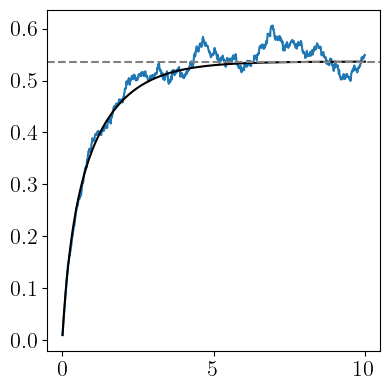

In [63]:
fig,ax = plt.subplots(1,1,figsize=(4,4))

ax.plot(t_axis, v_var_time*N)
ax.plot(t_axis, v_var_time_analytical, color='k')
ax.axhline(y=0.536462, color='gray', linestyle='dashed' )

plt.tight_layout()
plt.show()

In [66]:
v_all = np.array([])

for i in range(ens_size):
    
    file_name = f'{path}/data/burgers_R_{i:05d}_{dict_hash}.npz'
    
    vspace = ifft( np.load(file_name)['u'] , axis=1)[NTsave//2:,:].flatten()
    
    v_all = np.concatenate(( v_all, vspace ))

In [67]:
hist, bin_edges = np.histogram( np.real(v_all), bins=300, density=True )

bin_centers = .5*bin_edges[1:] + .5*bin_edges[:-1]

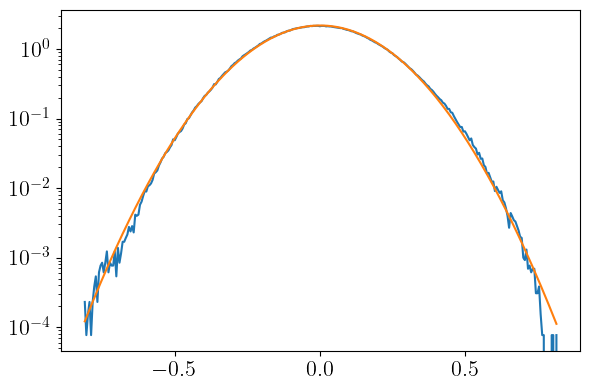

In [69]:
fig,ax = plt.subplots(1,1,figsize=(6,4))

ax.plot(bin_centers, hist)

ax.plot(bin_centers, f_pdf(bin_centers,0.536462*dx))

ax.set_yscale('log')

plt.tight_layout()
plt.show()

## Velocity Gradient Fourier Variance in Time

In [82]:
vg_var_time = np.zeros(NTsave)

for i in range(ens_size):
    
    file_name = f'{path}/data/burgers_R_{i:05d}_{dict_hash}.npz'
    
    vgfourier    = np.load(file_name)['dudx']
    
    vgspace      = ifft(vgfourier, axis=1)
    
    vg_var_time += np.mean( np.abs(vgfourier)**2 * dx, axis=1 )
    
vg_var_time *= 1./ens_size

In [83]:
# data copied from mathematica, HeatAnalytical.nb
vg_var_time_analytical = [1.86034, 3.60812, 5.25264, 6.80224, 8.26443, 9.64595, 10.9529, \
12.1908, 13.3646, 14.479, 15.5379, 16.5453, 17.5046, 18.4188, 19.291, \
20.1237, 20.9195, 21.6806, 22.4091, 23.1068, 23.7756, 24.4172, \
25.033, 25.6245, 26.193, 26.7398, 27.2659, 27.7725, 28.2606, 28.731, \
29.1848, 29.6226, 30.0453, 30.4536, 30.8481, 31.2296, 31.5985, \
31.9556, 32.3012, 32.636, 32.9603, 33.2747, 33.5795, 33.8752, \
34.1621, 34.4406, 34.7111, 34.9738, 35.2291, 35.4773, 35.7186, \
35.9533, 36.1816, 36.4039, 36.6203, 36.831, 37.0362, 37.2363, \
37.4312, 37.6213, 37.8066, 37.9874, 38.1638, 38.3359, 38.504, \
38.6681, 38.8283, 38.9849, 39.1379, 39.2874, 39.4335, 39.5764, \
39.7162, 39.8529, 39.9866, 40.1176, 40.2457, 40.3711, 40.494, \
40.6143, 40.7321, 40.8476, 40.9608, 41.0717, 41.1804, 41.287, \
41.3916, 41.4942, 41.5948, 41.6935, 41.7904, 41.8856, 41.9789, \
42.0706, 42.1607, 42.2491, 42.336, 42.4214, 42.5053, 42.5877, \
42.6688, 42.7485, 42.8268, 42.9039, 42.9797, 43.0543, 43.1276, \
43.1998, 43.2709, 43.3408, 43.4096, 43.4774, 43.5442, 43.6099, \
43.6746, 43.7384, 43.8012, 43.8631, 43.9241, 43.9842, 44.0435, \
44.1019, 44.1595, 44.2163, 44.2723, 44.3275, 44.382, 44.4357, \
44.4887, 44.541, 44.5927, 44.6436, 44.6939, 44.7435, 44.7925, \
44.8408, 44.8886, 44.9357, 44.9823, 45.0282, 45.0737, 45.1185, \
45.1628, 45.2066, 45.2499, 45.2926, 45.3349, 45.3766, 45.4179, \
45.4586, 45.499, 45.5388, 45.5782, 45.6172, 45.6557, 45.6938, \
45.7314, 45.7687, 45.8055, 45.842, 45.878, 45.9137, 45.949, 45.9839, \
46.0184, 46.0526, 46.0864, 46.1199, 46.153, 46.1857, 46.2182, \
46.2503, 46.2821, 46.3135, 46.3447, 46.3755, 46.406, 46.4362, \
46.4662, 46.4958, 46.5251, 46.5542, 46.5829, 46.6114, 46.6397, \
46.6676, 46.6953, 46.7227, 46.7498, 46.7767, 46.8034, 46.8298, \
46.8559, 46.8818, 46.9075, 46.9329, 46.9581, 46.9831, 47.0078, \
47.0323, 47.0566, 47.0807, 47.1045, 47.1282, 47.1516, 47.1748, \
47.1978, 47.2206, 47.2432, 47.2656, 47.2878, 47.3098, 47.3316, \
47.3532, 47.3746, 47.3958, 47.4169, 47.4378, 47.4584, 47.4789, \
47.4993, 47.5194, 47.5394, 47.5592, 47.5789, 47.5983, 47.6176, \
47.6368, 47.6557, 47.6746, 47.6932, 47.7117, 47.7301, 47.7482, \
47.7663, 47.7841, 47.8019, 47.8195, 47.8369, 47.8542, 47.8713, \
47.8883, 47.9052, 47.9219, 47.9385, 47.9549, 47.9712, 47.9874, \
48.0034, 48.0193, 48.0351, 48.0507, 48.0663, 48.0816, 48.0969, \
48.112, 48.127, 48.1419, 48.1567, 48.1713, 48.1859, 48.2003, 48.2146, \
48.2287, 48.2428, 48.2567, 48.2706, 48.2843, 48.2979, 48.3114, \
48.3247, 48.338, 48.3512, 48.3643, 48.3772, 48.3901, 48.4028, \
48.4155, 48.428, 48.4404, 48.4528, 48.465, 48.4772, 48.4892, 48.5012, \
48.513, 48.5248, 48.5364, 48.548, 48.5595, 48.5709, 48.5821, 48.5933, \
48.6045, 48.6155, 48.6264, 48.6373, 48.648, 48.6587, 48.6693, \
48.6798, 48.6902, 48.7006, 48.7108, 48.721, 48.7311, 48.7411, 48.751, \
48.7609, 48.7707, 48.7804, 48.79, 48.7995, 48.809, 48.8184, 48.8277, \
48.8369, 48.8461, 48.8552, 48.8642, 48.8732, 48.8821, 48.8909, \
48.8996, 48.9083, 48.9169, 48.9254, 48.9339, 48.9423, 48.9506, \
48.9589, 48.9671, 48.9753, 48.9833, 48.9913, 48.9993, 49.0072, \
49.015, 49.0227, 49.0304, 49.0381, 49.0457, 49.0532, 49.0606, 49.068, \
49.0754, 49.0826, 49.0899, 49.097, 49.1041, 49.1112, 49.1182, \
49.1251, 49.132, 49.1389, 49.1456, 49.1524, 49.159, 49.1657, 49.1722, \
49.1787, 49.1852, 49.1916, 49.198, 49.2043, 49.2106, 49.2168, \
49.2229, 49.2291, 49.2351, 49.2411, 49.2471, 49.253, 49.2589, \
49.2648, 49.2705, 49.2763, 49.282, 49.2876, 49.2932, 49.2988, \
49.3043, 49.3098, 49.3152, 49.3206, 49.326, 49.3313, 49.3365, \
49.3417, 49.3469, 49.3521, 49.3572, 49.3622, 49.3672, 49.3722, \
49.3771, 49.382, 49.3869, 49.3917, 49.3965, 49.4013, 49.406, 49.4106, \
49.4153, 49.4199, 49.4244, 49.429, 49.4335, 49.4379, 49.4423, \
49.4467, 49.4511, 49.4554, 49.4597, 49.4639, 49.4682, 49.4723, \
49.4765, 49.4806, 49.4847, 49.4887, 49.4928, 49.4968, 49.5007, \
49.5046, 49.5085, 49.5124, 49.5162, 49.5201, 49.5238, 49.5276, \
49.5313, 49.535, 49.5386, 49.5423, 49.5459, 49.5494, 49.553, 49.5565, \
49.56, 49.5634, 49.5669, 49.5703, 49.5737, 49.577, 49.5803, 49.5836, \
49.5869, 49.5902, 49.5934, 49.5966, 49.5998, 49.6029, 49.606, \
49.6091, 49.6122, 49.6153, 49.6183, 49.6213, 49.6243, 49.6272, \
49.6302, 49.6331, 49.6359, 49.6388, 49.6417, 49.6445, 49.6473, 49.65, \
49.6528, 49.6555, 49.6582, 49.6609, 49.6636, 49.6662, 49.6689, \
49.6715, 49.674, 49.6766, 49.6792, 49.6817, 49.6842, 49.6867, \
49.6891, 49.6916, 49.694, 49.6964, 49.6988, 49.7012, 49.7035, \
49.7058, 49.7082, 49.7105, 49.7127, 49.715, 49.7172, 49.7195, \
49.7217, 49.7239, 49.726, 49.7282, 49.7303, 49.7324, 49.7345, \
49.7366, 49.7387, 49.7408, 49.7428, 49.7448, 49.7468, 49.7488, \
49.7508, 49.7528, 49.7547, 49.7566, 49.7585, 49.7604, 49.7623, \
49.7642, 49.766, 49.7679, 49.7697, 49.7715, 49.7733, 49.7751, \
49.7769, 49.7786, 49.7804, 49.7821, 49.7838, 49.7855, 49.7872, \
49.7889, 49.7905, 49.7922, 49.7938, 49.7954, 49.797, 49.7986, \
49.8002, 49.8018, 49.8034, 49.8049, 49.8064, 49.808, 49.8095, 49.811, \
49.8125, 49.8139, 49.8154, 49.8168, 49.8183, 49.8197, 49.8211, \
49.8225, 49.8239, 49.8253, 49.8267, 49.8281, 49.8294, 49.8307, \
49.8321, 49.8334, 49.8347, 49.836, 49.8373, 49.8386, 49.8398, \
49.8411, 49.8424, 49.8436, 49.8448, 49.846, 49.8473, 49.8485, \
49.8497, 49.8508, 49.852, 49.8532, 49.8543, 49.8555, 49.8566, \
49.8577, 49.8589, 49.86, 49.8611, 49.8622, 49.8632, 49.8643, 49.8654, \
49.8664, 49.8675, 49.8685, 49.8696, 49.8706, 49.8716, 49.8726, \
49.8736, 49.8746, 49.8756, 49.8766, 49.8776, 49.8785, 49.8795, \
49.8804, 49.8814, 49.8823, 49.8832, 49.8841, 49.885, 49.886, 49.8869, \
49.8877, 49.8886, 49.8895, 49.8904, 49.8912, 49.8921, 49.8929, \
49.8938, 49.8946, 49.8954, 49.8963, 49.8971, 49.8979, 49.8987, \
49.8995, 49.9003, 49.9011, 49.9018, 49.9026, 49.9034, 49.9041, \
49.9049, 49.9056, 49.9064, 49.9071, 49.9078, 49.9086, 49.9093, 49.91, \
49.9107, 49.9114, 49.9121, 49.9128, 49.9135, 49.9142, 49.9148, \
49.9155, 49.9162, 49.9168, 49.9175, 49.9181, 49.9188, 49.9194, \
49.9201, 49.9207, 49.9213, 49.9219, 49.9225, 49.9232, 49.9238, \
49.9244, 49.925, 49.9255, 49.9261, 49.9267, 49.9273, 49.9279, \
49.9284, 49.929, 49.9295, 49.9301, 49.9306, 49.9312, 49.9317, \
49.9323, 49.9328, 49.9333, 49.9339, 49.9344, 49.9349, 49.9354, \
49.9359, 49.9364, 49.9369, 49.9374, 49.9379, 49.9384, 49.9389, \
49.9394, 49.9398, 49.9403, 49.9408, 49.9412, 49.9417, 49.9422, \
49.9426, 49.9431, 49.9435, 49.944, 49.9444, 49.9448, 49.9453, \
49.9457, 49.9461, 49.9466, 49.947, 49.9474, 49.9478, 49.9482, \
49.9486, 49.949, 49.9494, 49.9498, 49.9502, 49.9506, 49.951, 49.9514, \
49.9518, 49.9521, 49.9525, 49.9529, 49.9533, 49.9536, 49.954, \
49.9544, 49.9547, 49.9551, 49.9554, 49.9558, 49.9561, 49.9565, \
49.9568, 49.9572, 49.9575, 49.9578, 49.9582, 49.9585, 49.9588, \
49.9591, 49.9595, 49.9598, 49.9601, 49.9604, 49.9607, 49.961, \
49.9613, 49.9616, 49.9619, 49.9622, 49.9625, 49.9628, 49.9631, \
49.9634, 49.9637, 49.964, 49.9643, 49.9646, 49.9648, 49.9651, \
49.9654, 49.9657, 49.9659, 49.9662, 49.9665, 49.9667, 49.967, \
49.9672, 49.9675, 49.9678, 49.968, 49.9683, 49.9685, 49.9688, 49.969, \
49.9692, 49.9695, 49.9697, 49.97, 49.9702, 49.9704, 49.9707, 49.9709, \
49.9711, 49.9714, 49.9716, 49.9718, 49.972, 49.9722, 49.9725, \
49.9727, 49.9729, 49.9731, 49.9733, 49.9735, 49.9737, 49.9739, \
49.9742, 49.9744, 49.9746, 49.9748, 49.975, 49.9752, 49.9753, \
49.9755, 49.9757, 49.9759, 49.9761, 49.9763, 49.9765, 49.9767, \
49.9769, 49.977, 49.9772, 49.9774, 49.9776, 49.9778, 49.9779, \
49.9781, 49.9783, 49.9784, 49.9786, 49.9788, 49.9789, 49.9791, \
49.9793, 49.9794, 49.9796, 49.9798, 49.9799, 49.9801, 49.9802, \
49.9804, 49.9805, 49.9807, 49.9809, 49.981, 49.9812, 49.9813, \
49.9814, 49.9816, 49.9817, 49.9819, 49.982, 49.9822, 49.9823, \
49.9824, 49.9826, 49.9827, 49.9829, 49.983, 49.9831, 49.9833, \
49.9834, 49.9835, 49.9836, 49.9838, 49.9839, 49.984, 49.9842, \
49.9843, 49.9844, 49.9845, 49.9847, 49.9848, 49.9849, 49.985, \
49.9851, 49.9852, 49.9854, 49.9855, 49.9856, 49.9857, 49.9858, \
49.9859, 49.986, 49.9861, 49.9863, 49.9864, 49.9865, 49.9866, \
49.9867, 49.9868, 49.9869, 49.987, 49.9871, 49.9872, 49.9873, \
49.9874, 49.9875, 49.9876, 49.9877, 49.9878, 49.9879, 49.988, \
49.9881, 49.9882, 49.9883, 49.9884, 49.9884, 49.9885, 49.9886, \
49.9887, 49.9888, 49.9889, 49.989, 49.9891, 49.9892, 49.9892, \
49.9893, 49.9894, 49.9895, 49.9896, 49.9897, 49.9897, 49.9898, \
49.9899, 49.99, 49.9901, 49.9901, 49.9902, 49.9903, 49.9904, 49.9904, \
49.9905, 49.9906, 49.9907, 49.9907, 49.9908, 49.9909, 49.991, 49.991, \
49.9911, 49.9912, 49.9912, 49.9913, 49.9914, 49.9914, 49.9915, \
49.9916, 49.9916, 49.9917, 49.9918, 49.9918, 49.9919, 49.992, 49.992, \
49.9921, 49.9922, 49.9922, 49.9923, 49.9923, 49.9924, 49.9925, \
49.9925, 49.9926, 49.9926, 49.9927, 49.9927, 49.9928, 49.9929, \
49.9929, 49.993, 49.993, 49.9931, 49.9931, 49.9932, 49.9932, 49.9933, \
49.9934, 49.9934, 49.9935, 49.9935, 49.9936, 49.9936, 49.9937, \
49.9937, 49.9938, 49.9938, 49.9939, 49.9939, 49.994, 49.994, 49.994, \
49.9941, 49.9941, 49.9942, 49.9942, 49.9943, 49.9943, 49.9944, \
49.9944, 49.9945, 49.9945, 49.9945, 49.9946, 49.9946, 49.9947, \
49.9947]

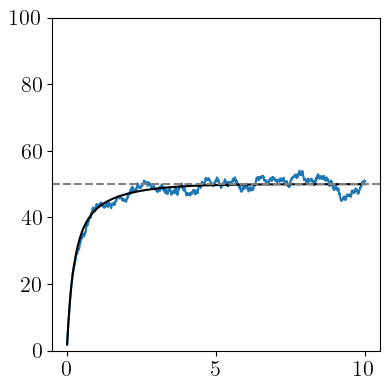

In [84]:
fig,ax = plt.subplots(1,1,figsize=(4,4))

ax.plot(t_axis, vg_var_time*N)
ax.plot(t_axis, vg_var_time_analytical, color='k')
ax.axhline(y=50., color='gray', linestyle='dashed' )
ax.set_ylim(0.,100.)

plt.tight_layout()
plt.show()

In [85]:
vg_all = np.array([])

for i in range(ens_size):
    
    file_name = f'{path}/data/burgers_R_{i:05d}_{dict_hash}.npz'
    
    vgspace = ifft( np.load(file_name)['dudx'] , axis=1)[NTsave//2:,:].flatten()
    
    vg_all = np.concatenate(( vg_all, vgspace ))

In [86]:
hist, bin_edges = np.histogram( np.real(vg_all), bins=300, density=True )

bin_centers = .5*bin_edges[1:] + .5*bin_edges[:-1]

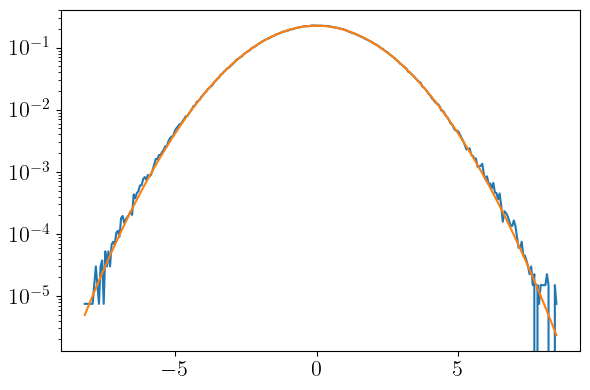

In [88]:
fig,ax = plt.subplots(1,1,figsize=(6,4))

ax.plot(bin_centers, hist)

ax.plot(bin_centers, f_pdf(bin_centers,50.*dx))

ax.set_yscale('log')

plt.tight_layout()
plt.show()